In [260]:
import os
import sys
import random
import math
import copy
from joblib import Parallel, delayed
file_path = "../TestInstance3/3-pr18.txt" 
import time
import concurrent.futures


In [261]:
class Node:
    def __init__(self, num, x, y, service_time, score, open_time, close_time):
        self.num = num
        self.x = x
        self.y = y
        self.service_time = service_time
        self.open_time = open_time
        self.close_time = close_time
        self.score = score


def is_feasible (tour, source):
    t_current=0
    t_max=source.close_time
    current_vertex=source
    # print("tour", tour)
    for i in range(len(tour)+1):
        next_vertex= None
        if i==len(tour):
            next_vertex= source
        else:
            next_vertex=tour[i]
        if max(t_current+math.dist([next_vertex.x,next_vertex.y],[current_vertex.x,current_vertex.y]),next_vertex.open_time)+next_vertex.service_time +math.dist([next_vertex.x,next_vertex.y],[source.x,source.y])>t_max:
            return False
        if (t_current + math.dist([next_vertex.x,next_vertex.y],[current_vertex.x,current_vertex.y]) <= next_vertex.close_time):
                t_current = max(t_current +math.dist([next_vertex.x,next_vertex.y],[current_vertex.x,current_vertex.y]), next_vertex.open_time) + next_vertex.service_time;
                current_vertex = next_vertex
            
        else: 
            return False
    return True

def calculate_score(solution, source):
    score=0
    for i in range(len(solution)):
        tour=solution[i]
        if is_feasible(tour, source):
            for j in range (len(tour)):
                score += tour[j].score
    return score

def solution_to_num(solution):
    solution_in_num = [[obj.num for obj in inner_list] for inner_list in solution]
    return solution_in_num

def tour_to_num(tour):
    tour_in_num = [obj.num for obj in tour]
    return tour_in_num

In [262]:
def euclidian_distance(first_node: Node, second_node: Node):
    return math.dist([first_node.x, first_node.y], [second_node.x, second_node.y])

def random_initial_solution(nodes, team_number):
    solution = []
    candidate = copy.deepcopy(nodes)
    source = nodes[0]
    t_max = source.close_time
    candidate.pop(0)
    
    for i in range(team_number):
        t_current = 0.0
        tour = []
        current_vertex = source
        counter = 0
        
        while len(candidate) > 0:
            random_candidate = random.randint(0, len(candidate) - 1)
            next_vertex = candidate[random_candidate]
            
            if (max(t_current + euclidian_distance(next_vertex, current_vertex), next_vertex.open_time) +
                    next_vertex.service_time + euclidian_distance(next_vertex, source)) > t_max:
                break
            
            if t_current + euclidian_distance(next_vertex, current_vertex) <= next_vertex.close_time:
                t_current = max(t_current + euclidian_distance(next_vertex, current_vertex),
                                next_vertex.open_time) + next_vertex.service_time
                tour.append(next_vertex)
                current_vertex = next_vertex
                candidate.pop(random_candidate)
            else:
                if counter == 30:
                    break
                else:
                    counter += 1
                    continue
        
        solution.append(tour)
    
    return solution


In [263]:



lines = []

with open(file_path, 'r') as file:
    for line in file:
        lines.append(line.rstrip())


k, v, N, t = map(int, lines[0].split())
v = 4
nodes = []
optimal_score = 0
for i, line in enumerate(lines[2:]):
    line_list = line.split()
    num = int(line_list[0])
    x = float(line_list[1])
    y = float(line_list[2])
    service_time = float(line_list[3])
    score = float(line_list[4])
    open_time = int(line_list[-2]) if lines.index(line) != 2 else 0
    close_time = int(line_list[-1]) if lines.index(line) != 2 else int(line_list[-1])
    node = Node(num, x, y, service_time, score, open_time, close_time)
    nodes.append(node)
    optimal_score+=score
source = nodes[0]
optimal_score


2006.0

In [264]:
# initial_solution = random_initial_solution(nodes, v)
# print(print_solution_num(initial_solution))
# calculate_score(initial_solution, source)

N

144

In [265]:
initial_population = []
population_size = 50
for i in range(population_size):
#     print(i)
    random_member = random_initial_solution(nodes, v)
    initial_population.append(random_member)

In [266]:
def repair_tour_in_solution(solution, index):
    tour = solution[index]
    tour_size = len(tour)
    
    for j in range(len(solution)):
        i = 0
        while i < tour_size:   
            if j != index and tour[i].num in tour_to_num(solution[j]):
                tour.pop(i)

                i -= 1
                tour_size -= 1
            i += 1
    solution[index] = tour
    return solution

def mutation_insert(solution, index):
    candidate = copy.deepcopy(nodes)
    candidate.pop(0)
    for i in range(len(solution)):
        for j in range(len(solution[i])):
                k = 0
                candidate_size = len(candidate)
                while k < candidate_size:
                    if candidate[k].num == solution[i][j].num:
                        candidate.pop(k)
                        break
                    k += 1
    tour = solution[index]
    random.shuffle(candidate)
    can_insert = False
    list_of_index = [i for i in range(len(tour)+1)] 
    random.shuffle(list_of_index)
    for i in random.choices(list_of_index, k=3):
        for j in range(len(candidate)):
            tour.insert(i, candidate[j])
            if is_feasible(tour, source):
                can_insert = True
                break
            else:
                tour.pop(i)
        if can_insert:
            break
    return solution

def mutation_remove(solution, index):
    tour = solution[index]
    if len(tour) <= 1 :
        return solution
    random_index = random.randint(0, len(tour)-1)
    tour.pop(random_index)
    return solution

def mutation_swap(solution, index):
    tour = solution[index]
    can_swap = 0
    for i in range(len(tour)):
        for j in range(i, len(tour)):
            tour[i], tour[j] = tour[j], tour[i]
            if not is_feasible(tour, source):
                tour[i], tour[j] = tour[j], tour[i]
            else:
                can_swap += 1
                break
        if can_swap == 1:
            break
    return solution

def cross_over_and_mutation(first, second, iteration):
    first_solution = copy.deepcopy(first)
    second_solution = copy.deepcopy(second)
    
    first_index = random.randint(0, v-1)
    second_index = random.randint(0, v-1)

    first_solution[first_index], second_solution[second_index] = second_solution[second_index], first_solution[first_index]

    first_solution = repair_tour_in_solution(first_solution, first_index)
    second_solution = repair_tour_in_solution(second_solution, second_index)
    
#     first_index = random.randint(0, v-1)
#     second_index = random.randint(0, v-1)

#     first_solution[first_index], second_solution[second_index] = second_solution[second_index], first_solution[first_index]

#     first_solution = repair_tour_in_solution(first_solution, first_index)
#     second_solution = repair_tour_in_solution(second_solution, second_index)

    
    for i in range(len(first_solution)):
        uniform_probability = random.uniform(0, 1)
        random_tour_index = random.randint(0, len(first_solution)-1)
        first_solution = mutation_swap(first_solution, random_tour_index)
        if uniform_probability >= 0.4:
            first_solution = mutation_insert(first_solution, random_tour_index)
        else:
            
            first_solution = mutation_remove(first_solution, random_tour_index)
    
    for i in range(len(second_solution)):
        uniform_probability = random.uniform(0, 1)
        random_tour_index = random.randint(0, len(second_solution)-1)
        second_solution = mutation_swap(second_solution, random_tour_index)
        if uniform_probability >= 0.4:
            second_solution = mutation_insert(second_solution, random_tour_index)
        else:
            second_solution = mutation_remove(second_solution, random_tour_index)
    
    
    return [first_solution, second_solution]


def cross_over(first, second):
    first_solution = copy.deepcopy(first)
    second_solution = copy.deepcopy(second)
    
    first_index = random.randint(0, v-1)
    print(first_index)
    second_index = random.randint(0, v-1)
    print(second_index)
    # first_index = 0
    # second_index = 1
    first_solution[first_index], second_solution[second_index] = second_solution[second_index], first_solution[first_index]
    repair_tour_in_solution(first_solution, first_index)
    repair_tour_in_solution(second_solution, second_index)
    
    return [first_solution, second_solution]



In [267]:
def generate_new_population(population):
    first_solution_index = random.randint(0, population_size-1)
    second_solution_index = random.randint(0, population_size-1)
    while second_solution_index == first_solution_index:
        second_solution_index = random.randint(0, population_size-1)
    
    return cross_over_and_mutation(population[first_solution_index], population[second_solution_index])
num_threads = 100
max_iteration = 50000
scores = []
population = copy.deepcopy(initial_population)
t_end = time.time() + 300
for i in range(max_iteration):
    if time.time() > t_end:
        break
    # population.sort(key=lambda i:calculate_score(i, source), reverse=True)
    # print(i, " ", calculate_score(population[0], source))
    new_population = []
    for j in range(population_size):
        
        first_solution_index = random.randint(0, population_size-1)
        second_solution_index = random.randint(0, population_size-1)
        while second_solution_index == first_solution_index:
            second_solution_index = random.randint(0, population_size-1)
        
        new_population += cross_over_and_mutation(population[first_solution_index], population[second_solution_index], i)
    # results = Parallel(n_jobs=4)(delayed(generate_new_population)(population) for i in range(100))
    
    # with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    #     # Submit each item to the executor
    #     futures = [executor.submit(generate_new_population, population) for i in range(100)]
    #     # Wait for all futures to complete
    #     concurrent.futures.wait(futures)
    # # print(futures[0].result())
    # # print(len(futures))
    # # print(len(results[0]))
    # new_population = []
    # for j in range(len(futures)):
    #     new_population += futures[j].result()
    
    pool = new_population + population
    # for i in range(le)
    pool.sort(key=lambda i:calculate_score(i, source), reverse=True)
    best_score = calculate_score(pool[0], source)
    best_solution = pool[0]
    scores.append(best_score)
    if (i+1) % 10 == 0:
        print(i+1, " ", calculate_score(pool[0], source))
    population = pool[:int(0.7*population_size)] + random.choices(pool[int(0.7*population_size):], k=int(0.3*population_size))
#     print(len(population))
        # print(solution_to_num(population[first_solution_index]))

        # print(solution_to_num(population[second_solution_index]))
        # print(solution_to_num(new_population[0]))

        # print(solution_to_num(new_population[1]))

    
        

10   704.0
20   795.0
30   917.0
40   930.0
50   969.0
60   974.0
70   998.0
80   1027.0
90   1048.0
100   1069.0
110   1096.0
120   1103.0
130   1123.0
140   1135.0
150   1153.0
160   1166.0
170   1168.0
180   1176.0
190   1200.0
200   1202.0
210   1207.0
220   1212.0
230   1219.0
240   1219.0
250   1219.0
260   1219.0
270   1223.0
280   1223.0
290   1226.0
300   1226.0
310   1226.0
320   1234.0
330   1234.0
340   1234.0
350   1234.0
360   1235.0
370   1235.0
380   1242.0
390   1245.0
400   1245.0
410   1245.0
420   1245.0
430   1245.0
440   1245.0
450   1250.0
460   1250.0
470   1250.0
480   1252.0
490   1253.0


In [268]:
population.sort(key=lambda i:calculate_score(i, source), reverse=True)
# best_solution = population[0]

In [269]:
solution_to_num(population[0])

[[54, 15, 76, 1, 55, 98, 20, 17, 71, 75, 44, 123, 115, 39, 93, 28, 47],
 [125,
  106,
  8,
  129,
  114,
  43,
  92,
  48,
  58,
  124,
  36,
  138,
  112,
  52,
  100,
  21,
  83,
  14,
  107],
 [13,
  59,
  68,
  45,
  108,
  37,
  119,
  87,
  6,
  105,
  41,
  56,
  24,
  135,
  46,
  77,
  72,
  144,
  99,
  127],
 [51, 113, 128, 140, 109, 133, 34, 23, 50, 65, 33, 136, 30, 2, 78, 137]]

In [270]:
for tour in best_solution:
    print(is_feasible(tour, source))

True
True
True
True


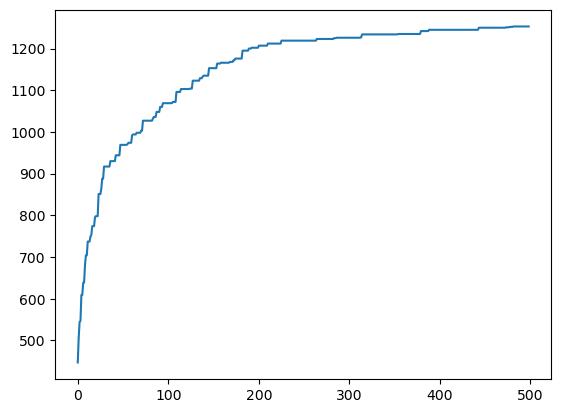

In [271]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(len(scores))],scores)

In [259]:
for tour in best_solution:
    each_tour = "0 "
    for node in tour:
        each_tour += str(node.num) + " "
    each_tour += "0"
    print(each_tour)


0 44 106 8 113 109 34 140 129 39 141 20 130 98 92 61 0
0 13 114 75 59 45 33 43 24 55 77 108 83 21 138 14 107 0
0 54 71 17 124 58 100 60 2 30 48 41 64 56 28 133 23 50 35 0
0 68 125 15 32 6 87 37 76 85 1 136 36 112 135 46 144 72 99 47 127 0


In [232]:
best_score

1146.0

In [233]:
i

157

In [152]:
res_line = []
with open("out3.txt", 'r') as file:
    for line in file:
        res_line.append(line.rstrip())
res_solution = []
all_res_node = []
for line in res_line:
    tour = []
    for node_id in line.split()[1:-1]:
        tour.append(nodes[int(node_id)])
        all_res_node.append(int(node_id))
    res_solution.append(tour)
if len(all_res_node) != len(set(all_res_node)):
    print("there is duplicate node")
else:
    print("there is no duplicate node")
for i in range(len(res_solution)):
    print(f"tour {i+1} is feasible: {is_feasible(res_solution[i], source)}")
print(f"score: {calculate_score(res_solution, source)}")

there is no duplicate node
tour 1 is feasible: False
tour 2 is feasible: False
tour 3 is feasible: False
tour 4 is feasible: False
tour 5 is feasible: True
tour 6 is feasible: True
score: 0
